In [1]:
import pandas as pd
import datetime

In [2]:
#read data 

sheet_url = "../../NESIP_FIELD_DATA/data.xlsx"
sheet_ea_day = "0. Energy Access(LP)"
sheet_ea_dump = "1. Energy Access Dump"
sheet_ea_passed = "2. Energy Access(Passed)"
sheet_ea_bad = "3. Energy Access(Bad)"

energy_access_day = pd.read_excel(sheet_url, sheet_ea_day)
ea_dump = pd.read_excel(sheet_url, sheet_ea_dump)
ea_passed = pd.read_excel(sheet_url, sheet_ea_passed)
ea_bad = pd.read_excel(sheet_url, sheet_ea_bad)


#sampling_numbers 
sampling_sheet = "Sampling Numbers"
sampling_numbers = pd.read_excel(sheet_url, sampling_sheet)



##### GENERATE METRICS

In [3]:
##### data collection progress
# Create Urban_Collected and Rural_Collected based on "Area Description"
ea_passed["Urban_Collected"] = (ea_passed["Area Description"] == "Urban").astype(int)
ea_passed["Rural_Collected"] = (ea_passed["Area Description"] == "Rural").astype(int)

ea_passed = pd.DataFrame(ea_passed)

# Group by State and LGA, sum Urban and Rural collected
summary_collected = ea_passed.groupby(["State", "LGA"])[["Urban_Collected", "Rural_Collected"]].sum().reset_index()


In [4]:
# Outer Join on 'LGA'
merged_collection_summ = pd.merge(sampling_numbers, summary_collected, on=['State', 'LGA'] , how='outer')

merged_collection_summ.fillna(0, inplace=True)

# Calculate Completion Percentage per LGA
merged_collection_summ["Urban_Completion"] = (merged_collection_summ["Urban_Collected"] / merged_collection_summ["Urban_Target"]) * 100
merged_collection_summ["Rural_Completion"] = (merged_collection_summ["Rural_Collected"] / merged_collection_summ["Rural_Target"]) * 100


In [5]:
merged_collection_summ[merged_collection_summ['State'] == 'Kwara']

,State,LGA,Urban_Target,Rural_Target,Total_Target,Urban_Collected,Rural_Collected,Urban_Completion,Rural_Completion
489,Kwara,Asa,6,3,9,6.0,3.0,100.000000,100.000000
490,Kwara,BarutenA,6,3,9,0.0,0.0,0.000000,0.000000
491,Kwara,Ekiti,6,3,9,7.0,3.0,116.666667,100.000000
492,Kwara,Ifelodun,6,3,9,6.0,3.0,100.000000,100.000000
493,Kwara,Ilorin East,6,3,9,6.0,4.0,100.000000,133.333333
494,Kwara,Ilorin West,6,3,9,7.0,2.0,116.666667,66.666667
495,Kwara,Ilorin south,6,3,9,0.0,0.0,0.000000,0.000000
496,Kwara,Irepodun,6,3,9,19.0,9.0,316.666667,300.000000
497,Kwara,Isin,6,3,9,14.0,8.0,233.333333,266.666667
498,Kwara,Kaiama,6,3,9,0.0,0.0,0.000000,0.000000


In [6]:
# Aggregate to State Level
state_completion = merged_collection_summ.groupby("State").agg(
    Urban_Completion=("Urban_Completion", "mean"),
    Rural_Completion=("Rural_Completion", "mean")
).reset_index()

# Calculate Overall Completion per State
state_completion["Overall_Completion"] = round((state_completion["Urban_Completion"] + state_completion["Rural_Completion"]) / 2,0)

state_data = state_completion.copy()


In [7]:
#### deficit to calculate percentage completion

# Calculate the Deficit (Data not yet collected)
merged_collection_summ["Urban_Deficit"] = merged_collection_summ["Urban_Target"] - merged_collection_summ["Urban_Collected"]
merged_collection_summ["Rural_Deficit"] = merged_collection_summ["Rural_Target"] - merged_collection_summ["Rural_Collected"]

# If collected >= target, set deficit to 0 (i.e., already completed)
merged_collection_summ["Urban_Deficit"] = merged_collection_summ["Urban_Deficit"].apply(lambda x: x if x > 0 else 0)
merged_collection_summ["Rural_Deficit"] = merged_collection_summ["Rural_Deficit"].apply(lambda x: x if x > 0 else 0)

# Sum the deficits and targets across all states and LGAs
total_urban_deficit = merged_collection_summ["Urban_Deficit"].sum()
total_rural_deficit = merged_collection_summ["Rural_Deficit"].sum()

total_urban_target = merged_collection_summ["Urban_Target"].sum()
total_rural_target = merged_collection_summ["Rural_Target"].sum()

# Total Deficit (Urban + Rural)
total_deficit = total_urban_deficit + total_rural_deficit

# Total Target (Urban + Rural)
total_target = total_urban_target + total_rural_target

# Overall Percentage Completion
overall_completion = round((1 - (total_deficit / total_target)) * 100,2)
perc_deficit =  round((100  - overall_completion), 2)

In [8]:
############################################################################
# completion date
urban_target = sampling_numbers['Urban_Target'].sum()
rural_target = sampling_numbers['Rural_Target'].sum()

total_target = urban_target + rural_target 

current_total  = total_target - total_deficit

In [9]:
# Assuming ea_passed is your DataFrame
ea_passed['Timestamp'] = pd.to_datetime(ea_passed['Timestamp'], format='%m/%d/%Y %H:%M:%S')
ea_passed['date'] = ea_passed['Timestamp'].dt.date

# Daily collection count
daily_collection_combined = ea_passed.groupby('date').size()

# Average daily collection
daily_avg_combined = round(daily_collection_combined.mean(), 0)

# Exclude the latest date
latest_date = daily_collection_combined.index.max()
daily_collection_excluding_latest = daily_collection_combined[daily_collection_combined.index != latest_date]
last_collection_df = daily_collection_combined[daily_collection_combined.index == latest_date]
last_collection_count =  len(last_collection_df)


# Average daily collection (excluding the latest date)
prev_daily_avg_combined = round(daily_collection_excluding_latest.mean(), 0)

perc_inc_dec_avg_col = round((daily_avg_combined - prev_daily_avg_combined)/prev_daily_avg_combined * 100, 0)

# Remaining surveys to be collected
remaining_total = max(total_target - current_total, 0)

# Calculate estimated completion time
days_to_complete = remaining_total / daily_avg_combined  # if daily_avg_combined > 0 else float('inf')

# Estimated completion date
today = datetime.date.today()
completion_date = today + datetime.timedelta(days=round(days_to_complete))

In [10]:
completion_date_text = completion_date.strftime('%B-%d-%Y')

expected_completion_date = "March 4th, 2025"

In [11]:
merged_collection_summ['Rural_Deficit'] = merged_collection_summ['Rural_Deficit'].round(0).astype(int)
merged_collection_summ['Urban_Deficit'] = merged_collection_summ['Urban_Deficit'].round(0).astype(int)

merged_collection_summ['Urban_Collected'] = merged_collection_summ['Urban_Collected'].round(0).astype(int)
merged_collection_summ['Rural_Collected'] = merged_collection_summ['Rural_Collected'].round(0).astype(int)


expander_data = merged_collection_summ[['State', 'LGA', 'Urban_Target', 'Rural_Target','Urban_Collected', 'Rural_Collected','Urban_Deficit', 'Rural_Deficit']]

In [12]:
state_data

,State,Urban_Completion,Rural_Completion,Overall_Completion
0,Abia,121.568627,102.205882,112.0
1,Adamawa,88.888889,86.904762,88.0
2,Akwa-Ibom,113.978495,108.064516,111.0
3,Anambra,90.952381,96.825397,94.0
4,Bauchi,86.666667,75.714286,81.0
5,Bayelsa,125.000000,105.357143,115.0
6,Benue,100.000000,104.891304,102.0
7,Borno,86.419753,86.419753,86.0
8,Cross River,107.407407,102.777778,105.0
9,Delta,104.800000,109.600000,107.0


In [13]:
## GET ALL METRICS
total_states = 37
states_done = len(state_data[(state_data['Urban_Completion'] >= 100) & (state_data['Rural_Completion'] >= 100)])

state_per_cmptd = round((states_done/total_states) *100, 2)
states_visited = f"{ea_passed['State'].nunique()} states visited"


In [14]:
# GOOD AND BAD DATA SUMMARY
good_bad_summary = ea_dump.pivot_table(
    index="State",
    columns="vista_remark",
    aggfunc="size",
    fill_value=0
).reset_index()

In [15]:
# Ensure "Good" and "Bad" columns are present even if some are missing
if "Good" not in good_bad_summary.columns:
    good_bad_summary["Good"] = 0
if "Bad" not in good_bad_summary.columns:
    good_bad_summary["Bad"] = 0

In [16]:
# Reorder columns for readability
good_bad_summary = good_bad_summary[['State', 'Good', 'Bad']]
good_bad_summary.rename(columns={"Good": "Clean Data", "Bad": "Inconsistent Data"}, inplace=True)

In [17]:
total_clean_records = good_bad_summary["Clean Data"].sum()
total_bad_records = good_bad_summary["Inconsistent Data"].sum()

In [18]:
Daily_avg_expected = 300

In [19]:
last_collection_count

1

##### CREATE THE SINGLE DATAFRAME

In [20]:
# generate  sinlge line df

dashboard_single_df = pd.DataFrame({
    'total_states' : [0],
    'states_done' : [0],  
    'state_per_cmptd' : [0],  
    'states_visited' : [0],
    'total_target' : [0],
    'current_total' : [0],
    'daily_avg_combined' :[0],
    'perc_inc_dec_avg_col' : [0],
    'expected_completion_date' :[0],
    'completion_date_text' :[0],
    'overall_completion' : [0],
    'perc_deficit' : [0],
    'total_clean_records' : [0],
    'total_bad_records' : [0],
    'Daily_avg_expected': [0],
    'perc_in_dec_collection': [0],
    'last_collection_count':[0]
})


In [21]:
dashboard_single_df.head()

,total_states,states_done,state_per_cmptd,states_visited,total_target,current_total,daily_avg_combined,perc_inc_dec_avg_col,expected_completion_date,completion_date_text,overall_completion,perc_deficit,total_clean_records,total_bad_records,Daily_avg_expected,perc_in_dec_collection,last_collection_count
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [22]:
dashboard_single_df['total_states'] = total_states,
dashboard_single_df['states_done'] = states_done,  
dashboard_single_df['state_per_cmptd'] = state_per_cmptd,  
dashboard_single_df['states_visited'] = states_visited  
dashboard_single_df['total_target'] = total_target  
dashboard_single_df['current_total'] = current_total
dashboard_single_df['daily_avg_combined'] = daily_avg_combined.round(0).astype(int)
dashboard_single_df['perc_inc_dec_avg_col'] = perc_inc_dec_avg_col.round(0).astype(int)
dashboard_single_df['expected_completion_date'] = expected_completion_date
dashboard_single_df['completion_date_text'] = completion_date_text
dashboard_single_df['overall_completion'] = overall_completion
dashboard_single_df['perc_deficit'] = perc_deficit
dashboard_single_df['total_clean_records'] = total_clean_records
dashboard_single_df['total_bad_records'] = total_bad_records
dashboard_single_df['Daily_avg_expected'] = Daily_avg_expected
dashboard_single_df['last_collection_count'] = last_collection_count 

In [23]:
dashboard_single_df.to_csv('../data/dashboard_data/dashboard_single_df.csv')

In [24]:
print(dashboard_single_df['completion_date_text'][0])


March-06-2025


##### OTHER TABLE METRICS

##### 1. GEOLOCATION

In [25]:
# 1. GEOLOACATION

# Ensure Geolocation is string and split into lat/lon
ea_passed['Geolocation'] = ea_passed['Geolocation'].astype(str)
ea_passed[['lat', 'lon']] = ea_passed['Geolocation'].str.split(',', expand=True)
ea_passed['lat'] = pd.to_numeric(ea_passed['lat'], errors='coerce')
ea_passed['lon'] = pd.to_numeric(ea_passed['lon'], errors='coerce')
ea_passed = ea_passed.dropna(subset=['lat', 'lon'])

In [26]:
geospatial_df = ea_passed[['State', 'LGA', 'lat', 'lon']]

In [27]:
geospatial_df.to_csv('../data/dashboard_data/geospatial_df.csv')

##### 2. STATE/LGA COMPLETION DATA

In [28]:
state_data.to_csv('../data/dashboard_data/state_lga_completion_data.csv')

##### 3. DATA QUALITY

In [29]:
good_bad_summary.to_csv('../data/dashboard_data/data_quality_summary.csv')

##### 4. DATA QUALITY

In [30]:
expander_data.to_csv('../data/dashboard_data/expander_df.csv')

#### 5. bad data count

In [31]:
# Convert 'Timestamp' to datetime format
ea_bad['Timestamp'] = pd.to_datetime(ea_bad['Timestamp'])

# Extract only the date
ea_bad['Date'] = ea_bad['Timestamp'].dt.date

# Group by Date and count occurrences
bad_data_trend_pivot = ea_bad.groupby('Date').size().reset_index(name='Dropped Data')


# Convert Date to string for proper visualization
bad_data_trend_pivot['Date'] = bad_data_trend_pivot['Date'].astype(str)

bad_data_trend_pivot.to_csv('../data/dashboard_data/bad_data_trend_pivot.csv')

#### 6. GET ENUMERATORS AND STATES PERFORMANCE DATA POINTS

In [32]:
# Group by State and count "Good" and "Bad"
STATE_GOOD = ea_dump.groupby(['State', 'vista_remark']).size().unstack(fill_value=0)

# Add a total count column
STATE_GOOD['Total'] = STATE_GOOD['Good'] + STATE_GOOD['Bad']

# Filter states with at least 50 data points
STATE_GOOD = STATE_GOOD[STATE_GOOD['Total'] >= 50]

# Calculate percentage of "Good"
STATE_GOOD['Data Quality'] = (STATE_GOOD['Good'] / STATE_GOOD['Total']) * 100


##### TOP 5 STATES

In [33]:
# Get top 5 states with the highest percentage of "Good"
top_5_states = STATE_GOOD.sort_values(by='Data Quality', ascending=False).head(5)

# Keep only State and Data Quality
top_5_states = top_5_states[['Data Quality']].reset_index()

# Ensure the final DataFrame has only the required columns
print(top_5_states)


top_5_states.to_csv('../data/dashboard_data/top_5_states.csv', index=False)

vista_remark   State  Data Quality
0                Oyo     98.475610
1               Ogun     97.656250
2             Rivers     97.627119
3                Edo     97.340426
4               Kogi     97.159091


##### BOTTOM 5 STATES

In [34]:
# Get top 5 states with the highest percentage of "Good"
BOTTOM_5_states = STATE_GOOD.sort_values(by='Data Quality', ascending=True).head(5)

# Keep only State and Data Quality
BOTTOM_5_states = BOTTOM_5_states[['Data Quality']].reset_index()

# Ensure the final DataFrame has only the required columns
print(BOTTOM_5_states)


BOTTOM_5_states.to_csv('../data/dashboard_data/BOTTOM_5_states.csv', index=False)

vista_remark        State  Data Quality
0                Nasarawa     83.333333
1                   Gombe     84.000000
2                     Imo     84.375000
3             Cross River     84.773663
4                   Ekiti     84.976526


##### Enumerators Analysis

In [35]:
# Group by State and count "Good" and "Bad"
enumerator_good = ea_dump.groupby(['Enumerator Name', 'vista_remark']).size().unstack(fill_value=0)

# Add a total count column
enumerator_good['Total'] = enumerator_good['Good'] + enumerator_good['Bad']

# Filter states with at least 50 data points
enumerator_good = enumerator_good[enumerator_good['Total'] >= 30]

# Calculate percentage of "Good"
enumerator_good['Data Quality'] = (enumerator_good['Good'] / enumerator_good['Total']) * 100


##### Top 5 Enumerators

In [36]:
# Get top 5 states with the highest percentage of "Good"
top_enumerators = enumerator_good.sort_values(by='Data Quality', ascending=False).head(30)

top_enumerators = top_enumerators[top_enumerators["Data Quality"] > 99.9]

# Keep only State and Data Quality
top_enumerators = top_enumerators[['Data Quality']].reset_index()

# Ensure the final DataFrame has only the required columns
print(top_enumerators)


top_enumerators.to_csv('../data/dashboard_data/top_enumerators.csv', index=False)

vista_remark            Enumerator Name  Data Quality
0                         ALEX AFAHOKOR         100.0
1                        Adamaka Aguruo         100.0
2                     Bamidele akinyemi         100.0
3                           Collin Zino         100.0
4                        Akpovwovwo joy         100.0
5                   Arisekola Ebunoluwa         100.0
6                           Agha Nnenna         100.0
7                 Adeyemi oluwadamilare         100.0
8                       Fadeyi Odunlayo         100.0
9                    Irechukwu Princess         100.0
10                 munirat Ahmad busari         100.0
11                      mathew usiosefe         100.0
12                      marvelous unung         100.0
13                          liatu Adamu         100.0
14                         BELLO YUNUSA         100.0
15                     Ayomide olawoyin         100.0
16                     Chinyere Ejiofor         100.0
17                       Ife

##### bottom performing enumerators

In [37]:
# Get top 5 states with the highest percentage of "Good"
bottom_enumerators = enumerator_good.sort_values(by='Data Quality', ascending=True).head(5)

# Keep only State and Data Quality
bottom_enumerators = bottom_enumerators[['Data Quality']].reset_index()

# Ensure the final DataFrame has only the required columns
print(bottom_enumerators)


bottom_enumerators.to_csv('../data/dashboard_data/bottom_enumerators.csv', index=False)

vista_remark     Enumerator Name  Data Quality
0              Ndifon Ntoni Edim     52.777778
1                Olalere Olawale     60.000000
2               Christopher AUDU     71.875000
3                Olubunmi Mayowa     72.972973
4             Ubong Godwin Aaron     73.170732


In [38]:
expander_data["State"].unique().tolist()

['Abia',
 'Adamawa',
 'Akwa-Ibom',
 'Anambra',
 'Bauchi',
 'Bayelsa',
 'Benue',
 'Borno',
 'Cross River',
 'Delta',
 'Ebonyi',
 'Edo',
 'Ekiti',
 'Enugu',
 'Federal Capital Territory',
 'Gombe',
 'Imo',
 'Jigawa',
 'Kaduna',
 'Kano',
 'Kastina',
 'Kebbi',
 'Kogi',
 'Kwara',
 'Lagos',
 'Nasarawa',
 'Niger',
 'Ogun',
 'Ondo',
 'Osun',
 'Oyo',
 'Plateau',
 'Rivers',
 'Sokoto',
 'Taraba',
 'Yobe',
 'Zamfara']

: 

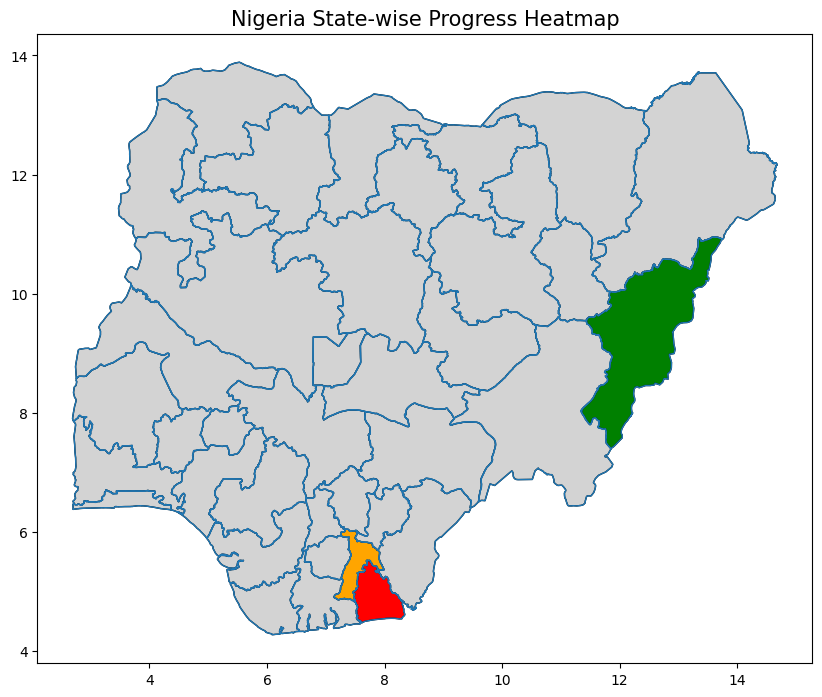

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Load Nigeria state boundaries
url = "https://github.com/wmgeolab/geoBoundaries/raw/main/releaseData/gbOpen/NGA/ADM1/geoBoundaries-NGA-ADM1.geojson"
nigeria_states = gpd.read_file(url)

# Sample progress dataset (replace with actual dataset)
progress_data = pd.DataFrame({
    "State": ["Abia", "Adamawa", "Akwa Ibom"],
    "Progress": ["Ongoing", "Done", "Pending"]
})

# Merge state boundaries with progress data
nigeria_states = nigeria_states.merge(progress_data, left_on="shapeName", right_on="State", how="left")

# Define color mapping
colors = {"Done": "green", "Ongoing": "orange", "Pending": "red"}

# Apply colors and handle NaN values
nigeria_states["Color"] = nigeria_states["Progress"].map(colors).fillna("lightgray")

# Plot the heatmap
fig, ax = plt.subplots(figsize=(10, 10))
nigeria_states.boundary.plot(ax=ax, linewidth=1)
nigeria_states.plot(ax=ax, color=nigeria_states["Color"], edgecolor="black", legend=True)

# Add title
plt.title("State Progress Heatmap", fontsize=15)
plt.savefig("../data/dashboard_data/nigeria_heatmap.png", dpi=300)


